In [ ]:
import os, numpy as np, config
from PIL import Image, ImageDraw
import util
from importlib import reload

reload(util)

# ------------------------------------------------------------------ constants
SIDE   = 224                      # target size (square)
S      = config.S
ANCHOR = config.ANCHORS[0]        # (w₀, h₀) in relative units





# ------------------------------------------------------------------ main
def render_gt(gt_df, img_id,
              *, colour=(0, 255, 0, 200),
              out_dir="evaluation",
              size=SIDE):
    ann = gt_df[gt_df.img_id == img_id]
    if ann.empty:
        raise ValueError(f"no rows with img_id={img_id}")

    img_path = os.path.join(config.img_dir, ann.filename.iloc[0])
    pil = Image.open(img_path).convert("RGB").resize((size, size))

    draw = ImageDraw.Draw(pil, "RGBA")
    for _, row in ann.iterrows():
        draw.rectangle(util._gt_box_from_row(row), outline=colour, width=2)

    os.makedirs(out_dir, exist_ok=True)
    out_path = os.path.join(out_dir, f"{img_id}_gt_only.png")
    pil.save(out_path)
    print(f"[render_gt] saved → {out_path}")
    return pil

In [8]:
import util
from importlib import reload
import model as m

reload(util)
reload(config)

de = util.DataExtractor()
gt_df = de.croppedData()


Saving to: c:\Users\alexh\Desktop\cv2\obb_anns_hausarbeit\ds2_dense\ds2_dense\gt_space.json


[render_gt] saved → evaluation\1023_gt_only.png


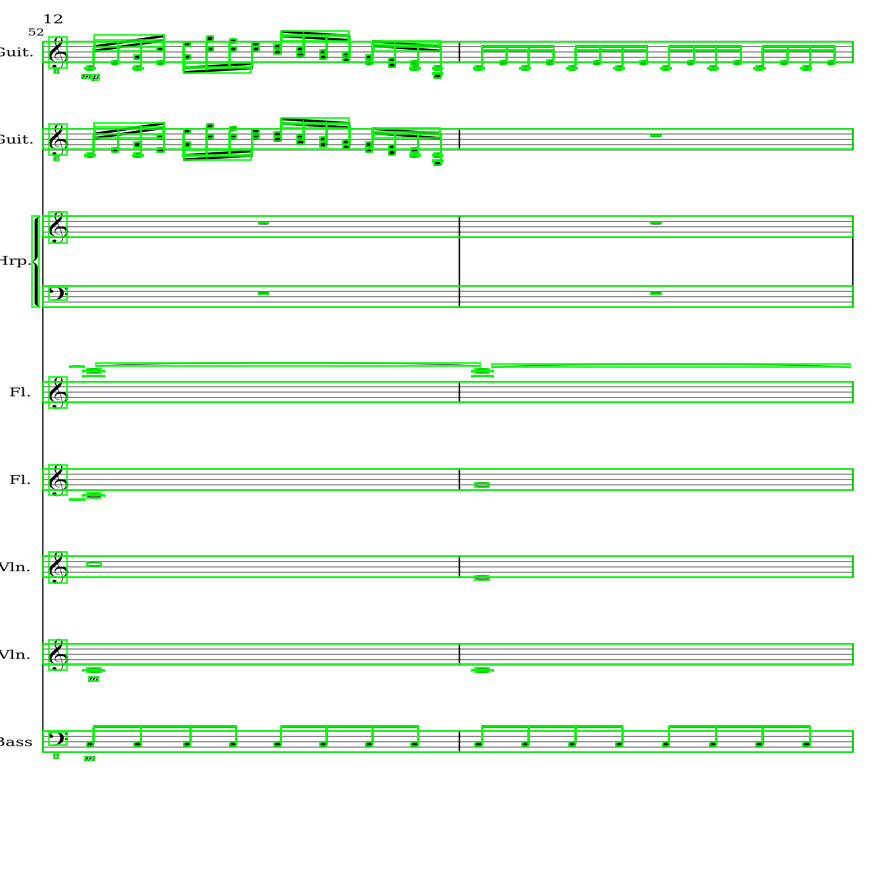

In [10]:
render_gt(gt_df, img_id=1023)

## Predictions

In [103]:
import pandas as pd
import util
from importlib import reload

reload(util)
reload(config)
gt_df = util.DataExtractor().croppedData()

Saving to: c:\Users\alexh\Desktop\cv2\obb_anns_hausarbeit\ds2_dense\ds2_dense\gt_space.json


In [104]:
df = gt_df.set_index("crop_uid")


In [102]:
df.head()

,img_id,crop_id,cx_loc,cy_loc,tx,ty,tw,th,class_id,filename,cx,cy,crop_row,crop_col
group_uid,,,,,,,,,,,,,,
4668,679,1,20,6,0.000000,0.019192,3.772461,0.249753,134,lg-877777775968732096-aug-gonville--page-3.png,60,6,0,1
4668,679,1,20,11,0.000000,0.951149,3.772461,0.249753,134,lg-877777775968732096-aug-gonville--page-3.png,60,11,0,1
4669,679,2,13,19,0.566434,0.627799,-0.489309,-2.856328,1,lg-877777775968732096-aug-gonville--page-3.png,93,19,0,2
4669,679,2,13,20,0.640477,0.203548,-0.591092,-3.261793,1,lg-877777775968732096-aug-gonville--page-3.png,93,20,0,2
4669,679,2,10,19,0.925545,0.627799,-0.522099,-2.856328,1,lg-877777775968732096-aug-gonville--page-3.png,90,19,0,2


In [ ]:
import os, numpy as np, config
from PIL import Image, ImageDraw


def render_crop_gt(
        gt_df, img_id,
        *, crop_cells, row_idx, col_idx,
        colour=(255, 0, 0, 200),
        out_dir="evaluation_crops",
        size=config.RES):
    
    """size       : output edge length (kept 896 for parity)"""

    if S % crop_cells:
        raise ValueError(f"crop_cells={crop_cells} must divide {S}")
    crops_per_dim = S // crop_cells
    if not (0 <= row_idx < crops_per_dim and 0 <= col_idx < crops_per_dim):
        raise ValueError("row_idx / col_idx outside valid range")

    page = gt_df[gt_df.img_id == img_id]
    if page.empty:
        raise ValueError(f"No rows with img_id={img_id}")

    # ---------- crop window in cell coordinates --------------------------------
    cx_min = col_idx * crop_cells
    cx_max = (col_idx + 1) * crop_cells       # exclusive
    cy_min = row_idx * crop_cells
    cy_max = (row_idx + 1) * crop_cells

    crop_boxes = page[(page.cx >= cx_min) & (page.cx < cx_max) &
                      (page.cy >= cy_min) & (page.cy < cy_max)]
    if crop_boxes.empty:
        raise ValueError("No GT boxes inside the requested crop")

    # ---------- prepare full-page canvas (896×896) ------------------------------
    img_path = os.path.join(config.img_dir, crop_boxes.filename.iloc[0])
    full = Image.open(img_path).convert("RGB").resize((config.RES, config.RES))

    # pixel window of the crop on that 896×896 full canvas
    cell_px   = config.RES / config.S                       # width/height of one grid cell
    crop_px   = crop_cells * cell_px           # edge length of the crop region
    left_px   = int(round(col_idx * crop_px))
    top_px    = int(round(row_idx * crop_px))
    right_px  = int(round(left_px + crop_px))
    lower_px  = int(round(top_px  + crop_px))

    # cut & upscale to full 896×896 preview
    crop_img  = full.crop((left_px, top_px, right_px, lower_px)).resize((size, size))
    scale     = size / (right_px - left_px)    # same for x and y

    # ---------- draw ------------------------------------------------------------
    draw = ImageDraw.Draw(crop_img, "RGBA")
    for _, row in crop_boxes.iterrows():
        x0, y0, x1, y1 = _gt_box_from_row(row)
        # shift into crop coords, then upscale
        box = [(x0 - left_px) * scale,
               (y0 - top_px)  * scale,
               (x1 - left_px) * scale,
               (y1 - top_px)  * scale]
        draw.rectangle(box, outline=colour, width=2)

    # ---------- save / return ---------------------------------------------------
    os.makedirs(out_dir, exist_ok=True)
    name = f"{img_id}_r{row_idx}_c{col_idx}_cells{crop_cells}.png"
    out_path = os.path.join(out_dir, name)
    crop_img.save(out_path)
    print(f"[render_crop_gt] saved → {out_path}")
    return crop_img


[render_crop_gt] saved → evaluation_crops\895_r0_c8_cells10.png


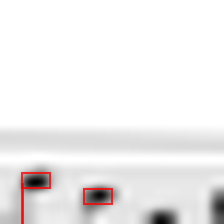

In [43]:
render_crop_gt(gt_df,
               img_id=895,
               crop_cells=10,
               row_idx=0,
               col_idx=8)

In [ ]:
import os, numpy as np, config
from PIL import Image, ImageDraw
from importlib import reload
import config
import util

reload(util)
reload(config)







def render_crop_gt_loc(df, crop_uid,
                       *, crop_id=None, crop_row=None, crop_col=None,
                       colour=(0, 255, 0, 200),
                       out_dir="evaluation_crops_loc",
                       size=config.RES):
    subset = df[df.crop_uid == crop_uid]
    if subset.empty:
        raise ValueError(f"crop_uid {crop_uid} not in dataframe")

    # ---------------------------------------------------------------- pick crop
    if crop_uid is not None:
        crop_rows = subset[subset.crop_uid == crop_uid]
        if crop_rows.empty:
            valid = sorted(subset.crop_id.unique())
            raise ValueError(f"crop_id {crop_id} not found for crop_uid {crop_uid}.\n"
                             f"Valid crop_id values: {valid[:20]}…")
        crop_row = int(crop_rows.crop_row.iloc[0])
        crop_col = int(crop_rows.crop_col.iloc[0])
    else:
        if crop_row is None or crop_col is None:
            raise ValueError("Pass either crop_id or both crop_row and crop_col")
        crop_rows = subset[(subset.crop_row == crop_row) &
                           (subset.crop_col == crop_col)]
        if crop_rows.empty:
            raise ValueError(f"No rows at crop_row={crop_row}, crop_col={crop_col}")


    # ---------------------------------------------------------------- load page
    img_path = os.path.join(config.img_dir, crop_rows.filename.iloc[0])
    crop_img, left_px, top_px, scale = util.load_crop_image(img_path, crop_row, crop_col, full_size=SIDE, crop_size=size)

    util.drawCropBoxes(crop_rows, crop_img, top_px, left_px, scale)

    # ---------------------------------------------------------------- save / return
    os.makedirs(out_dir, exist_ok=True)
    name = (f"{crop_uid}_crop{crop_id}.png" if crop_id is not None
            else f"{crop_uid}_r{crop_row}_c{crop_col}.png")
    out_path = os.path.join(out_dir, name)
    crop_img.save(out_path)
    print(f"[render_crop_gt_loc] saved → {name}")
    return crop_img


[render_crop_gt_loc] saved → 1000_crop8.png


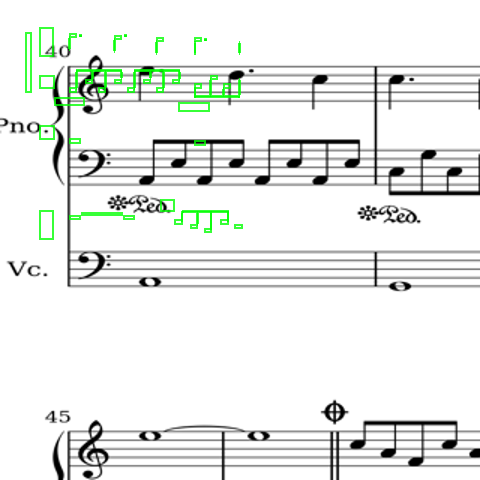

In [148]:
import util
from importlib import reload
import config
reload(util)
reload(config)

render_crop_gt_loc(gt_df, crop_uid = 1000, crop_id = 8, size = config.RES)